In [2]:
# Q1 – Part A – Load and preprocess SMS Spam dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# load dataset (update path if needed)
df = pd.read_csv("/content/spam.csv", encoding="latin-1")[['v1', 'v2']]
df.columns = ['label', 'text']

# map labels to 0/1
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# simple text cleaning function
stop_words = set(stopwords.words('english'))
punct_table = str.maketrans('', '', string.punctuation)

def clean_text(s):
    s = str(s).lower()
    s = s.translate(punct_table)
    tokens = [w for w in s.split() if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

# TF-IDF features
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['clean_text'])
y = df['label_num'].values

# train-test split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# class distribution
print("Class distribution in full data:")
print(df['label_num'].value_counts(normalize=True))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Class distribution in full data:
label_num
0    0.865937
1    0.134063
Name: proportion, dtype: float64


In [3]:
# Q1 – Part B – Decision stump baseline

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))


Train accuracy: 0.8837783262284048
Test accuracy: 0.8923766816143498
Confusion matrix (test):
[[930  36]
 [ 84  65]]


Iteration 1
Misclassified indices: [  14   42   49   50   59   62   86   93   96  100  103  115  121  140
  142  157  162  194  195  196  203  224  263  294  295  300  302  321
  327  343  344  351  352  361  369  370  389  395  404  408  417  429
  446  449  458  460  461  472  477  478  486  500  501  512  513  514
  533  542  544  559  580  591  596  602  614  623  626  647  674  677
  679  690  716  732  733  743  744  750  768  769  777  781  788  790
  802  803  838  845  867  870  882  884  900  907  922  927  930  955
  964  969  972  974  978 1010 1013 1016 1036 1046 1047 1067 1080 1098
 1100 1103 1112 1114 1132 1177 1179 1214 1218 1223 1238 1242 1246 1253
 1281 1292 1293 1294 1297 1299 1309 1314 1315 1326 1329 1332 1346 1357
 1364 1365 1374 1390 1414 1435 1452 1453 1455 1458 1468 1469 1473 1481
 1482 1495 1498 1512 1519 1533 1541 1556 1561 1570 1597 1602 1613 1627
 1646 1650 1658 1677 1683 1698 1709 1710 1711 1716 1725 1731 1738 1749
 1772 1775 1798 1804 1807 1808 1817 1818 1

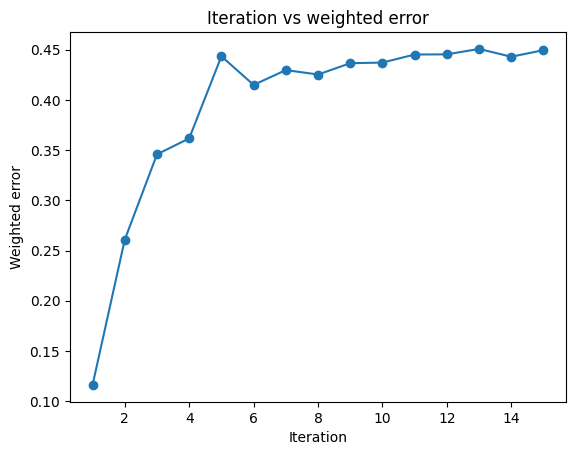

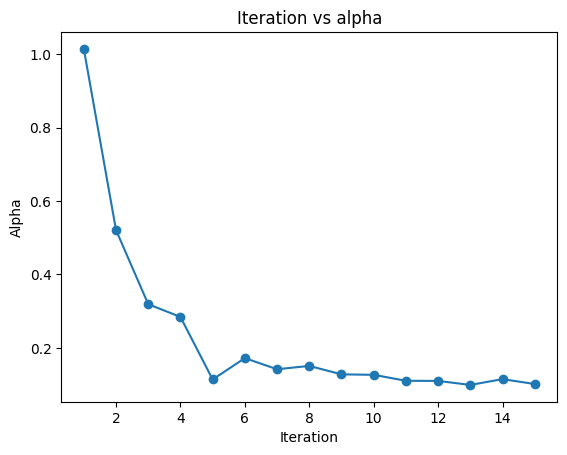

In [4]:
# Q1 – Part C – Manual AdaBoost (T = 15) with decision stumps

import matplotlib.pyplot as plt

T = 15
n_train = X_train.shape[0]

w = np.ones(n_train) / n_train
alphas = []
errors = []
stumps = []

for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump_t.fit(X_train, y_train, sample_weight=w)
    y_pred_t = stump_t.predict(X_train)

    misclassified = (y_pred_t != y_train).astype(int)
    err_t = np.dot(w, misclassified) / np.sum(w)

    # avoid division by zero
    err_t = np.clip(err_t, 1e-10, 1 - 1e-10)
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)

    # print info for this iteration
    mis_idx = np.where(misclassified == 1)[0]
    print(f"Iteration {t+1}")
    print("Misclassified indices:", mis_idx)
    print("Weights of misclassified samples:", w[mis_idx])
    print("Alpha:", alpha_t)
    print("-" * 40)

    # update weights
    w = w * np.exp(-alpha_t * (2 * y_train - 1) * (2 * y_pred_t - 1))
    w = w / np.sum(w)

    alphas.append(alpha_t)
    errors.append(err_t)
    stumps.append(stump_t)

# function to get final strong prediction
def predict_adaboost(X):
    final = np.zeros(X.shape[0])
    for alpha_t, stump_t in zip(alphas, stumps):
        pred = stump_t.predict(X)
        final += alpha_t * (2 * pred - 1)
    return (final > 0).astype(int)

y_train_boost = predict_adaboost(X_train)
y_test_boost = predict_adaboost(X_test)

print("Manual AdaBoost train accuracy:", accuracy_score(y_train, y_train_boost))
print("Manual AdaBoost test accuracy:", accuracy_score(y_test, y_test_boost))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_boost))

# plots
plt.figure()
plt.plot(range(1, T+1), errors, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Weighted error")
plt.title("Iteration vs weighted error")
plt.show()

plt.figure()
plt.plot(range(1, T+1), alphas, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.title("Iteration vs alpha")
plt.show()


In [6]:
# Q1 – Part D – Sklearn AdaBoost (fixed for new sklearn)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

ada_sklearn = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)

ada_sklearn.fit(X_train, y_train)

y_train_ada = ada_sklearn.predict(X_train)
y_test_ada = ada_sklearn.predict(X_test)

print("Sklearn AdaBoost train accuracy:", accuracy_score(y_train, y_train_ada))
print("Sklearn AdaBoost test accuracy:", accuracy_score(y_test, y_test_ada))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_ada))


Sklearn AdaBoost train accuracy: 0.9169845187345749
Sklearn AdaBoost test accuracy: 0.9246636771300448
Confusion matrix (test):
[[966   0]
 [ 84  65]]


<---------Question 2-------->


In [8]:
# Q2 (Heart) – Part A – Load from CSV and baseline stump

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# change filename to your actual heart dataset file
df_heart = pd.read_csv("/content/heart.csv")

# assume 'target' is the label column (0/1)
X_heart = df_heart.drop(columns=['target']).values
y_heart = df_heart['target'].values

scaler = StandardScaler()
X_heart_scaled = scaler.fit_transform(X_heart)

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    X_heart_scaled, y_heart, test_size=0.2, random_state=42, stratify=y_heart
)

stump_heart = DecisionTreeClassifier(max_depth=1, random_state=42)
stump_heart.fit(Xh_train, yh_train)

yh_train_pred = stump_heart.predict(Xh_train)
yh_test_pred = stump_heart.predict(Xh_test)

print("Heart stump train acc:", accuracy_score(yh_train, yh_train_pred))
print("Heart stump test acc:", accuracy_score(yh_test, yh_test_pred))
print("Confusion matrix (test):")
print(confusion_matrix(yh_test, yh_test_pred))
print("Classification report (test):")
print(classification_report(yh_test, yh_test_pred))


Heart stump train acc: 0.7727272727272727
Heart stump test acc: 0.7049180327868853
Confusion matrix (test):
[[19  9]
 [ 9 24]]
Classification report (test):
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        28
           1       0.73      0.73      0.73        33

    accuracy                           0.70        61
   macro avg       0.70      0.70      0.70        61
weighted avg       0.70      0.70      0.70        61



n_estimators=5, lr=0.1, test acc=0.7049
n_estimators=5, lr=0.5, test acc=0.8197
n_estimators=5, lr=1.0, test acc=0.7377
n_estimators=10, lr=0.1, test acc=0.7377
n_estimators=10, lr=0.5, test acc=0.8525
n_estimators=10, lr=1.0, test acc=0.8033
n_estimators=25, lr=0.1, test acc=0.8197
n_estimators=25, lr=0.5, test acc=0.8361
n_estimators=25, lr=1.0, test acc=0.7869
n_estimators=50, lr=0.1, test acc=0.8033
n_estimators=50, lr=0.5, test acc=0.8361
n_estimators=50, lr=1.0, test acc=0.7541
n_estimators=100, lr=0.1, test acc=0.8525
n_estimators=100, lr=0.5, test acc=0.8197
n_estimators=100, lr=1.0, test acc=0.8197


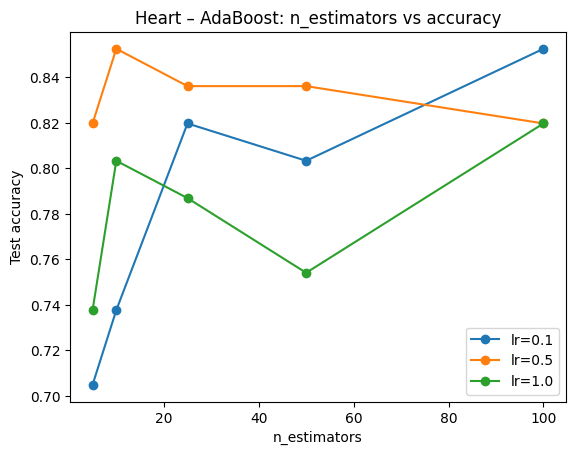

Best config (n, lr, acc): (10, 0.5, 0.8524590163934426)


In [10]:
# Q2 (Heart) – Part B – AdaBoost with grid over n_estimators and learning_rate

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_list = [5, 10, 25, 50, 100]
lr_list = [0.1, 0.5, 1.0]

results = []

for n in n_list:
    for lr in lr_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
            n_estimators=n,
            learning_rate=lr,
            random_state=42
        )
        ada.fit(Xh_train, yh_train)
        yh_test_pred = ada.predict(Xh_test)
        acc = accuracy_score(yh_test, yh_test_pred)
        results.append((n, lr, acc))
        print(f"n_estimators={n}, lr={lr}, test acc={acc:.4f}")

plt.figure()
for lr in lr_list:
    xs = [n for n, lr2, acc in results if lr2 == lr]
    ys = [acc for n, lr2, acc in results if lr2 == lr]
    plt.plot(xs, ys, marker='o', label=f"lr={lr}")
plt.xlabel("n_estimators")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Heart – AdaBoost: n_estimators vs accuracy")
plt.show()

best_cfg = max(results, key=lambda x: x[2])
print("Best config (n, lr, acc):", best_cfg)


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


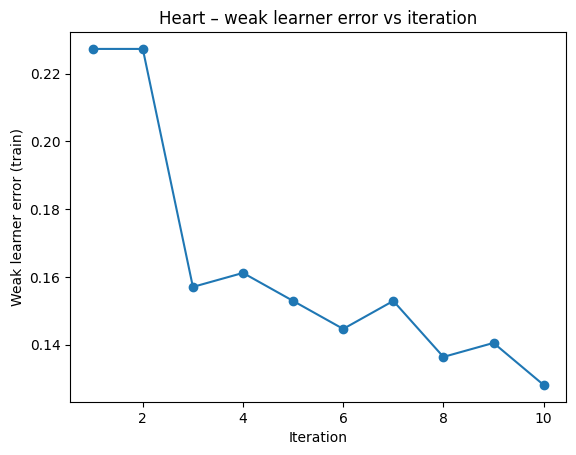

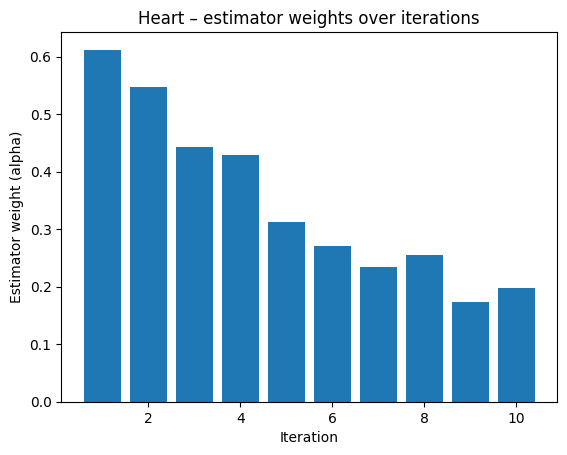

In [11]:
# Q2 (Heart) – Part C – Misclassification pattern for best model

best_n, best_lr, _ = best_cfg

best_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=best_n,
    learning_rate=best_lr,
    algorithm='SAMME',
    random_state=42
)
best_ada.fit(Xh_train, yh_train)

staged_errors = []
for yh_stage in best_ada.staged_predict(Xh_train):
    staged_errors.append(1 - accuracy_score(yh_train, yh_stage))

plt.figure()
plt.plot(range(1, best_n + 1), staged_errors, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Weak learner error (train)")
plt.title("Heart – weak learner error vs iteration")
plt.show()

final_weights = best_ada.estimator_weights_
plt.figure()
plt.bar(range(1, len(final_weights) + 1), final_weights)
plt.xlabel("Iteration")
plt.ylabel("Estimator weight (alpha)")
plt.title("Heart – estimator weights over iterations")
plt.show()


In [12]:
# Q2 (Heart) – Part D – Feature importance and top 5

import numpy as np

feat_importance = best_ada.feature_importances_
indices = np.argsort(feat_importance)[::-1]

print("Feature importances (descending):")
for i in indices:
    print(df_heart.columns[i], feat_importance[i])

top5 = indices[:5]
print("\nTop 5 features:")
for i in top5:
    print(df_heart.columns[i])


Feature importances (descending):
ca 0.18426946967141783
cp 0.17613466463608776
oldpeak 0.17333395200359505
thal 0.15747504449653826
exang 0.08991131162204231
slope 0.07799717378570604
sex 0.07334664683919759
chol 0.06753173694541519
thalach 0.0
fbs 0.0
restecg 0.0
trestbps 0.0
age 0.0

Top 5 features:
ca
cp
oldpeak
thal
exang


In [ ]:
# Q3 (WISDM) – Part A – Data preparation

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

path = "WISDM_ar_v1.1_raw.txt"

rows = []
with open(path) as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) < 6:
            continue
        try:
            user_id = parts[0]
            activity = parts[1]
            x = float(parts[3])
            y = float(parts[4])
            z = float(parts[5].split(';')[0])
            rows.append([user_id, activity, x, y, z])
        except:
            continue

wisdm = pd.DataFrame(rows, columns=['user_id', 'activity', 'x', 'y', 'z'])

vigorous = ['Jogging', 'Upstairs']
wisdm['label'] = wisdm['activity'].apply(
    lambda a: 1 if any(v.lower() in a.lower() for v in vigorous) else 0
)

wisdm = wisdm.dropna()

X_w = wisdm[['x', 'y', 'z']].values
y_w = wisdm['label'].values

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_w, y_w, test_size=0.3, random_state=42, stratify=y_w
)

print("Train shape:", Xw_train.shape, "Test shape:", Xw_test.shape)
print("Label distribution train:", np.bincount(yw_train))
print("Label distribution test:", np.bincount(yw_test))


In [13]:
# Q3 (WISDM) – Part A – Data preparation

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

path = "WISDM_ar_v1.1_raw.txt"

rows = []
with open(path) as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) < 6:
            continue
        try:
            user_id = parts[0]
            activity = parts[1]
            x = float(parts[3])
            y = float(parts[4])
            z = float(parts[5].split(';')[0])
            rows.append([user_id, activity, x, y, z])
        except:
            continue

wisdm = pd.DataFrame(rows, columns=['user_id', 'activity', 'x', 'y', 'z'])

vigorous = ['Jogging', 'Upstairs']
wisdm['label'] = wisdm['activity'].apply(
    lambda a: 1 if any(v.lower() in a.lower() for v in vigorous) else 0
)

wisdm = wisdm.dropna()

X_w = wisdm[['x', 'y', 'z']].values
y_w = wisdm['label'].values

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_w, y_w, test_size=0.3, random_state=42, stratify=y_w
)

print("Train shape:", Xw_train.shape, "Test shape:", Xw_test.shape)
print("Label distribution train:", np.bincount(yw_train))
print("Label distribution test:", np.bincount(yw_test))


Train shape: (768742, 3) Test shape: (329461, 3)
Label distribution train: [443211 325531]
Label distribution test: [189947 139514]


In [14]:
# Q3 (WISDM) – Part B – Decision stump baseline

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump_w = DecisionTreeClassifier(max_depth=1, random_state=42)
stump_w.fit(Xw_train, yw_train)

yw_train_pred = stump_w.predict(Xw_train)
yw_test_pred = stump_w.predict(Xw_test)

print("Train accuracy:", accuracy_score(yw_train, yw_train_pred))
print("Test accuracy:", accuracy_score(yw_test, yw_test_pred))
print("Confusion matrix (test):")
print(confusion_matrix(yw_test, yw_test_pred))


Train accuracy: 0.6522370314097578
Test accuracy: 0.652171273686415
Confusion matrix (test):
[[172337  17610]
 [ 96986  42528]]


Iteration 1
Misclassified indices: [     2      7      8 ... 768735 768739 768741]
Weights of misclassified samples: [1.30082655e-06 1.30082655e-06 1.30082655e-06 ... 1.30082655e-06
 1.30082655e-06 1.30082655e-06]
Alpha: 0.3144434590020354
----------------------------------------
Iteration 2
Misclassified indices: [     7      8     10 ... 768737 768739 768741]
Weights of misclassified samples: [1.87027755e-06 1.87027755e-06 1.87027755e-06 ... 9.97203840e-07
 1.87027755e-06 1.87027755e-06]
Alpha: 0.07022220347135695
----------------------------------------
Iteration 3
Misclassified indices: [     0      1      2 ... 768736 768738 768740]
Weights of misclassified samples: [9.31873014e-07 9.31873014e-07 1.74774816e-06 ... 9.31873014e-07
 9.31873014e-07 9.31873014e-07]
Alpha: 0.10328545877548205
----------------------------------------
Iteration 4
Misclassified indices: [     1      7     10 ... 768734 768735 768737]
Weights of misclassified samples: [1.03878444e-06 1.82359828e-06 1.82359

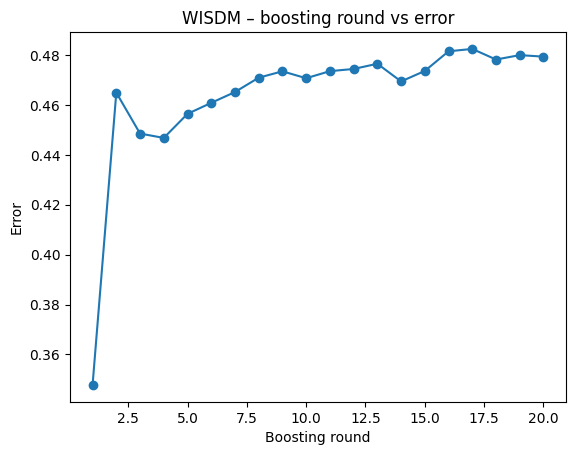

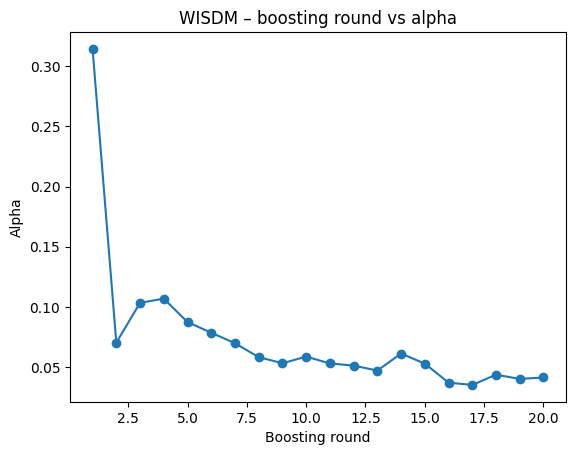

In [15]:
# Q3 (WISDM) – Part C – Manual AdaBoost (T = 20 rounds)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

T_w = 20
n_train_w = Xw_train.shape[0]

w_w = np.ones(n_train_w) / n_train_w
alphas_w = []
errors_w = []
stumps_w = []

for t in range(T_w):
    stump_t = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump_t.fit(Xw_train, yw_train, sample_weight=w_w)
    y_pred_t = stump_t.predict(Xw_train)

    misclassified = (y_pred_t != yw_train).astype(int)
    err_t = np.dot(w_w, misclassified) / np.sum(w_w)
    err_t = np.clip(err_t, 1e-10, 1 - 1e-10)
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)

    mis_idx = np.where(misclassified == 1)[0]
    print(f"Iteration {t+1}")
    print("Misclassified indices:", mis_idx)
    print("Weights of misclassified samples:", w_w[mis_idx])
    print("Alpha:", alpha_t)
    print("-" * 40)

    w_w = w_w * np.exp(-alpha_t * (2 * yw_train - 1) * (2 * y_pred_t - 1))
    w_w = w_w / np.sum(w_w)

    alphas_w.append(alpha_t)
    errors_w.append(err_t)
    stumps_w.append(stump_t)

def predict_adaboost_w(X):
    final = np.zeros(X.shape[0])
    for alpha_t, stump_t in zip(alphas_w, stumps_w):
        pred = stump_t.predict(X)
        final += alpha_t * (2 * pred - 1)
    return (final > 0).astype(int)

yw_train_boost = predict_adaboost_w(Xw_train)
yw_test_boost = predict_adaboost_w(Xw_test)

print("Manual AdaBoost (WISDM) train acc:", accuracy_score(yw_train, yw_train_boost))
print("Manual AdaBoost (WISDM) test acc:", accuracy_score(yw_test, yw_test_boost))
print("Confusion matrix (test):")
print(confusion_matrix(yw_test, yw_test_boost))

plt.figure()
plt.plot(range(1, T_w + 1), errors_w, marker='o')
plt.xlabel("Boosting round")
plt.ylabel("Error")
plt.title("WISDM – boosting round vs error")
plt.show()

plt.figure()
plt.plot(range(1, T_w + 1), alphas_w, marker='o')
plt.xlabel("Boosting round")
plt.ylabel("Alpha")
plt.title("WISDM – boosting round vs alpha")
plt.show()


In [16]:
# Q3 (WISDM) – Part D – Sklearn AdaBoost

from sklearn.ensemble import AdaBoostClassifier

ada_w = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)
ada_w.fit(Xw_train, yw_train)

yw_train_ada = ada_w.predict(Xw_train)
yw_test_ada = ada_w.predict(Xw_test)

print("Sklearn AdaBoost (WISDM) train acc:", accuracy_score(yw_train, yw_train_ada))
print("Sklearn AdaBoost (WISDM) test acc:", accuracy_score(yw_test, yw_test_ada))
print("Confusion matrix (test):")
print(confusion_matrix(yw_test, yw_test_ada))


Sklearn AdaBoost (WISDM) train acc: 0.6980092150552462
Sklearn AdaBoost (WISDM) test acc: 0.6977912408448952
Confusion matrix (test):
[[165890  24057]
 [ 75509  64005]]
